In [14]:
#Importando as Bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu, shapiro

In [15]:
# Carregando o dataset
df = pd.read_csv("Brasileirao.csv", delimiter=",")
df.head()

,ano_campeonato,data,gols_mandante,gols_visitante,publico,publico_max,time_mandante,time_visitante
0,2012,2012-05-27,1.0,0.0,18277.0,NaN,Grêmio,Palmeiras
1,2012,2012-07-01,0.0,1.0,34550.0,NaN,Grêmio,Atlético-MG
2,2012,2012-07-18,3.0,1.0,15179.0,NaN,Grêmio,Sport Recife
3,2012,2012-07-25,1.0,0.0,27405.0,NaN,Grêmio,Fluminense
4,2012,2012-08-15,1.0,2.0,15798.0,NaN,Grêmio,Portuguesa


In [ ]:
#TRATAMENTO DOS DADOS

#Selecionando apenas os jogos do Corinthians
df_cor = df[(df['time_mandante'] == 'Corinthians') | (df['time_visitante'] == 'Corinthians')].copy()

#Retirando o ano de 2020 por conta da pandemia
df_cor['data'] = pd.to_datetime(df_cor['data'], errors='coerce')
df_cor = df_cor[df_cor['data'].dt.year != 2020]

# Adicionando colunas auxiliares
df_cor['em_casa'] = df_cor['time_mandante'] == 'Corinthians'
df_cor['gols_corinthians'] = df_cor.apply(
    lambda row: row['gols_mandante'] if row['em_casa'] else row['gols_visitante'], axis=1)
df_cor['gols_adversario'] = df_cor.apply(
    lambda row: row['gols_visitante'] if row['em_casa'] else row['gols_mandante'], axis=1)
df_cor['saldo_gols'] = df_cor['gols_corinthians'] - df_cor['gols_adversario']
df_cor['local'] = df_cor['em_casa'].map({True: 'Casa', False: 'Fora'})

df_cor.head()

,ano_campeonato,data,gols_mandante,gols_visitante,publico,publico_max,time_mandante,time_visitante,em_casa,gols_corinthians,gols_adversario,saldo_gols,local
31,2012,2012-07-29,0.0,0.0,24648.0,NaN,EC Bahia,Corinthians,False,0.0,0.0,0.0,Fora
42,2012,2012-07-18,0.0,3.0,14897.0,NaN,Flamengo,Corinthians,False,3.0,0.0,3.0,Fora
68,2012,2012-09-16,0.0,2.0,24692.0,43600.0,Palmeiras,Corinthians,False,2.0,0.0,2.0,Fora
84,2012,2012-08-29,1.0,1.0,9062.0,NaN,Fluminense,Corinthians,False,1.0,1.0,0.0,Fora
111,2012,2012-05-20,0.0,1.0,14791.0,37730.0,Corinthians,Fluminense,True,0.0,1.0,-1.0,Casa


In [18]:
# Separando por local
casa = df_cor[df_cor['em_casa']]
fora = df_cor[~df_cor['em_casa']]

In [19]:
# Estatísticas descritivas 
gols_stats = pd.concat([
    casa['gols_corinthians'].describe().round(2).rename("Casa"),
    fora['gols_corinthians'].describe().round(2).rename("Fora")
], axis=1)

saldo_stats = pd.concat([
    casa['saldo_gols'].describe().round(2).rename("Casa"),
    fora['saldo_gols'].describe().round(2).rename("Fora")
], axis=1)

print("===== Estatísticas: Gols =====")
print(gols_stats)

print("\n===== Estatísticas: Saldo de Gols =====")
print(saldo_stats)


===== Estatísticas: Gols =====
         Casa    Fora
count  381.00  380.00
mean     1.51    1.05
std      1.22    1.04
min      0.00    0.00
25%      1.00    0.00
50%      1.00    1.00
75%      2.00    2.00
max      7.00    5.00

===== Estatísticas: Saldo de Gols =====
         Casa    Fora
count  381.00  380.00
mean     0.61   -0.19
std      1.52    1.40
min     -5.00   -5.00
25%      0.00   -1.00
50%      1.00    0.00
75%      1.00    1.00
max      6.00    4.00


In [24]:
#Teste de Normalidade
print("\n===== Teste de Normalidade (Shapiro-Wilk) =====")
print("Gols - Casa:", shapiro(casa['gols_corinthians']))
print("Gols - Fora:", shapiro(fora['gols_corinthians']))
print("Saldo - Casa:", shapiro(casa['saldo_gols']))
print("Saldo - Fora:", shapiro(fora['saldo_gols']))


===== Teste de Normalidade (Shapiro-Wilk) =====
Gols - Casa: ShapiroResult(statistic=0.8766739854096572, pvalue=6.979440494937062e-17)
Gols - Fora: ShapiroResult(statistic=0.8365480146147037, pvalue=2.185276146873852e-19)
Saldo - Casa: ShapiroResult(statistic=0.9430964874245047, pvalue=6.430712901589431e-11)
Saldo - Fora: ShapiroResult(statistic=0.9511831942522873, pvalue=6.866596395370754e-10)


In [21]:
# Testes de Mann-Whitney 
stat_gols, p_gols = mannwhitneyu(casa['gols_corinthians'], fora['gols_corinthians'], alternative='two-sided')
stat_saldo, p_saldo = mannwhitneyu(casa['saldo_gols'], fora['saldo_gols'], alternative='two-sided')

print(f"\n===== Testes de Mann-Whitney =====")
print(f"Gols do Corinthians: U={stat_gols}, p={p_gols:.4e}")
print(f"Saldo de Gols: U={stat_saldo}, p={p_saldo:.4e}")


===== Testes de Mann-Whitney =====
Gols do Corinthians: U=88650.0, p=2.1573e-08
Saldo de Gols: U=95690.5, p=3.2165e-15


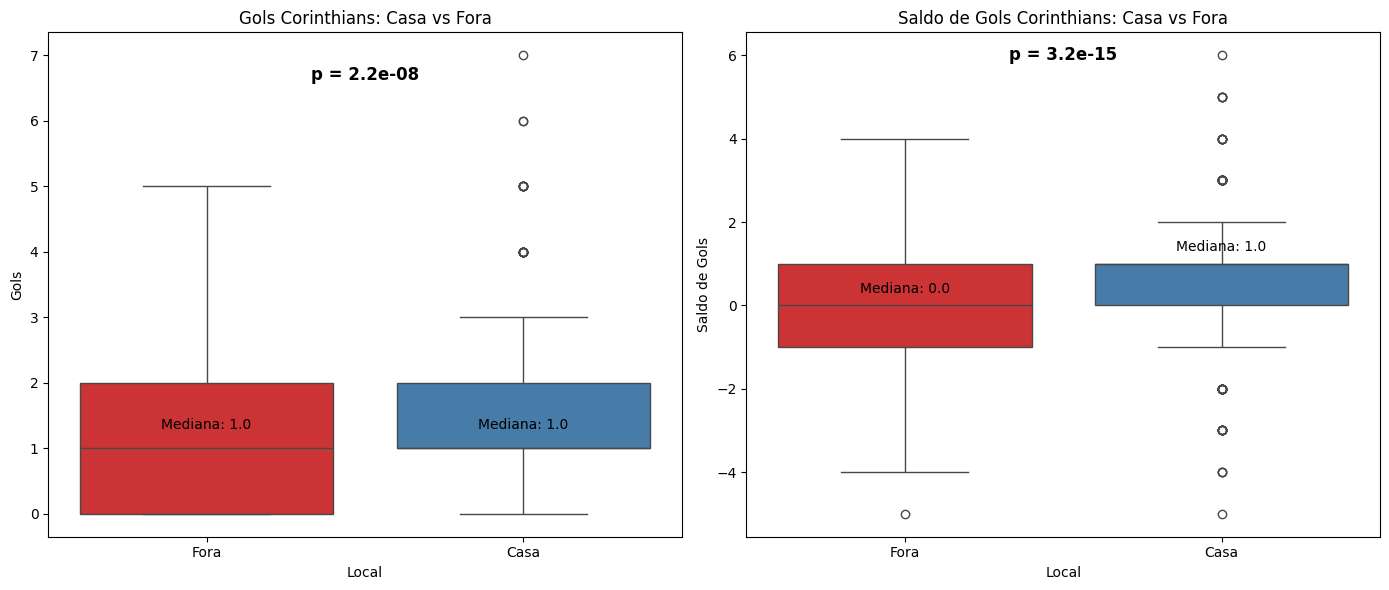

In [22]:
# Visualização com boxplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gols do Corinthians
sns.boxplot(data=df_cor, x='local', y='gols_corinthians', hue='local', ax=axs[0], palette='Set1', legend=False)
axs[0].set_title('Gols Corinthians: Casa vs Fora')
axs[0].set_ylabel('Gols')
axs[0].set_xlabel('Local')

# Saldo de gols
sns.boxplot(data=df_cor, x='local', y='saldo_gols', hue='local', ax=axs[1], palette='Set1', legend=False)
axs[1].set_title('Saldo de Gols Corinthians: Casa vs Fora')
axs[1].set_ylabel('Saldo de Gols')
axs[1].set_xlabel('Local')

# Anotando mediana e p-valor nos gráficos
for ax, col, p_val in zip(axs, ['gols_corinthians', 'saldo_gols'], [p_gols, p_saldo]):
    medians = df_cor.groupby('local')[col].median()
    for i, loc in enumerate(['Fora', 'Casa']):
        ax.text(i, medians[loc] + 0.3, f'Mediana: {medians[loc]:.1f}', ha='center', fontsize=10, color='black')
    ax.text(0.5, ax.get_ylim()[1]*0.9, f'p = {p_val:.1e}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

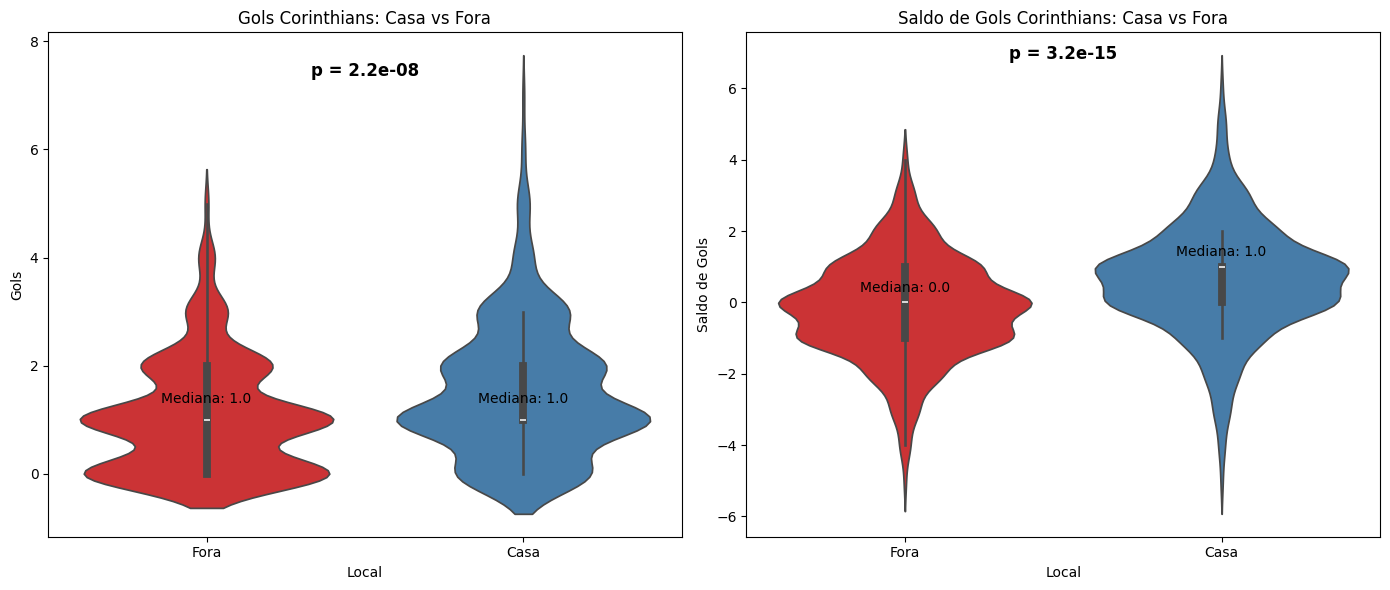

In [23]:
# Visualização com violinplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Gols do Corinthians
sns.violinplot(data=df_cor, x='local', y='gols_corinthians', hue='local', ax=axs[0], palette='Set1', legend=False, inner='box')
axs[0].set_title('Gols Corinthians: Casa vs Fora')
axs[0].set_ylabel('Gols')
axs[0].set_xlabel('Local')

# Saldo de gols
sns.violinplot(data=df_cor, x='local', y='saldo_gols', hue='local', ax=axs[1], palette='Set1', legend=False, inner='box')
axs[1].set_title('Saldo de Gols Corinthians: Casa vs Fora')
axs[1].set_ylabel('Saldo de Gols')
axs[1].set_xlabel('Local')

# Anotando mediana e p-valor nos gráficos
for ax, col, p_val in zip(axs, ['gols_corinthians', 'saldo_gols'], [p_gols, p_saldo]):
    medians = df_cor.groupby('local')[col].median()
    for i, loc in enumerate(['Fora', 'Casa']):
        ax.text(i, medians[loc] + 0.3, f'Mediana: {medians[loc]:.1f}', ha='center', fontsize=10, color='black')
    ax.text(0.5, ax.get_ylim()[1]*0.9, f'p = {p_val:.1e}', ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()
